## Libraries

In [2]:
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.datasets.imdb as imdb

import matplotlib.pyplot as plt
import matplotlib

import os,sys,h5py,json

## Parameters

In [3]:
vocab_size           = 10000
hide_most_frequently = 0

review_len           = 256
dense_vector_size    = 32

epochs               = 10
batch_size           = 128

fit_verbosity        = 1
scale                = 1

## Data

In [4]:
(x_train, y_train), (x_test, y_test) = imdb.load_data( num_words=vocab_size, skip_top=hide_most_frequently, seed= 42,)

y_train = np.asarray(y_train).astype('float32')
y_test  = np.asarray(y_test ).astype('float32')

# ---- Rescale
#
n1 = int(scale * len(x_train))
n2 = int(scale * len(x_test))
x_train, y_train = x_train[:n1], y_train[:n1]
x_test,  y_test  = x_test[:n2],  y_test[:n2]

# ---- About
print("x_train : {}  y_train : {}".format(x_train.shape, y_train.shape))
print("x_test  : {}  y_test  : {}".format(x_test.shape,  y_test.shape))

x_train : (25000,)  y_train : (25000,)
x_test  : (25000,)  y_test  : (25000,)


In [5]:
# ---- Retrieve dictionary {word:index}, and encode it in ascii
#
word_index = imdb.get_word_index()

# ---- Shift the dictionary from +3
#
word_index = {w:(i+3) for w,i in word_index.items()}

# ---- Add <pad>, <start> and unknown tags
#
word_index.update( {'<pad>':0, '<start>':1, '<unknown>':2} )

# ---- Create a reverse dictionary : {index:word}
#
index_word = {index:word for word,index in word_index.items()} 

# ---- Add a nice function to transpose :
#
def dataset2text(review):
    return ' '.join([index_word.get(i, '?') for i in review])

In [6]:
print('Dictionary size     : ', len(word_index))
for k in range(440,455):print(f'{k:2d} : {index_word[k]}' )
print('Review example :')
print(x_train[12])
print('After translation :')
print(dataset2text(x_train[12]))

Dictionary size     :  88587
440 : hope
441 : entertaining
442 : she's
443 : mr
444 : overall
445 : evil
446 : called
447 : loved
448 : based
449 : oh
450 : several
451 : fans
452 : mother
453 : drama
454 : beginning
Review example :
[1, 14, 22, 1367, 53, 206, 159, 4, 636, 898, 74, 26, 11, 436, 363, 108, 7, 14, 432, 14, 22, 9, 1055, 34, 8599, 2, 5, 381, 3705, 4509, 14, 768, 47, 839, 25, 111, 1517, 2579, 1991, 438, 2663, 587, 4, 280, 725, 6, 58, 11, 2714, 201, 4, 206, 16, 702, 5, 5176, 19, 480, 5920, 157, 13, 64, 219, 4, 2, 11, 107, 665, 1212, 39, 4, 206, 4, 65, 410, 16, 565, 5, 24, 43, 343, 17, 5602, 8, 169, 101, 85, 206, 108, 8, 3008, 14, 25, 215, 168, 18, 6, 2579, 1991, 438, 2, 11, 129, 1609, 36, 26, 66, 290, 3303, 46, 5, 633, 115, 4363]
After translation :
<start> this film contains more action before the opening credits than are in entire hollywood films of this sort this film is produced by tsui <unknown> and stars jet li this team has brought you many worthy hong kong cinema prod

In [7]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                     value   = 0,
                                                     padding = 'post',
                                                     maxlen  = review_len)

x_test  = keras.preprocessing.sequence.pad_sequences(x_test,
                                                     value   = 0 ,
                                                     padding = 'post',
                                                     maxlen  = review_len)

print('After padding :')
print(x_train[12])
print('In real words :')
print(dataset2text(x_train[12]))

After padding :
[   1   14   22 1367   53  206  159    4  636  898   74   26   11  436
  363  108    7   14  432   14   22    9 1055   34 8599    2    5  381
 3705 4509   14  768   47  839   25  111 1517 2579 1991  438 2663  587
    4  280  725    6   58   11 2714  201    4  206   16  702    5 5176
   19  480 5920  157   13   64  219    4    2   11  107  665 1212   39
    4  206    4   65  410   16  565    5   24   43  343   17 5602    8
  169  101   85  206  108    8 3008   14   25  215  168   18    6 2579
 1991  438    2   11  129 1609   36   26   66  290 3303   46    5  633
  115 4363    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0 

## GRU model

In [8]:
def get_recurrentModel(dense_vector_size=128):
    
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim = vocab_size, output_dim = dense_vector_size))
    model.add(keras.layers.GRU(50))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer = 'rmsprop',
                  loss      = 'binary_crossentropy',
                  metrics   = ['accuracy'])
    return model

In [9]:
model = get_recurrentModel(32)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 gru (GRU)                   (None, 50)                12600     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 332,651
Trainable params: 332,651
Non-trainable params: 0
_________________________________________________________________


In [10]:
output_dir='Text'

os.makedirs(f'{output_dir}/models',   mode=0o750, exist_ok=True)
save_dir = f'{output_dir}/models/best_model.h5'
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

In [11]:
history = model.fit(x_train,
                    y_train,
                    epochs          = epochs,
                    batch_size      = batch_size,
                    validation_data = (x_test, y_test),
                    verbose         = fit_verbosity,
                    callbacks       = [savemodel_callback])

Epoch 1/10
196/196 [==============================] - 37s 176ms/step - loss: 0.7054 - accuracy: 0.5430 - val_loss: 0.6646 - val_accuracy: 0.5583
Epoch 2/10
196/196 [==============================] - 35s 177ms/step - loss: 0.7552 - accuracy: 0.6774 - val_loss: 0.5357 - val_accuracy: 0.7820
Epoch 3/10
196/196 [==============================] - 34s 174ms/step - loss: 0.5435 - accuracy: 0.7620 - val_loss: 0.4763 - val_accuracy: 0.8098
Epoch 4/10
196/196 [==============================] - 35s 178ms/step - loss: 0.4647 - accuracy: 0.8131 - val_loss: 0.4844 - val_accuracy: 0.7955
Epoch 5/10
196/196 [==============================] - 34s 174ms/step - loss: 0.4217 - accuracy: 0.8376 - val_loss: 0.4353 - val_accuracy: 0.8319
Epoch 6/10
196/196 [==============================] - 35s 181ms/step - loss: 0.4240 - accuracy: 0.8362 - val_loss: 0.4769 - val_accuracy: 0.7879
Epoch 7/10
196/196 [==============================] - 35s 178ms/step - loss: 0.3999 - accuracy: 0.8503 - val_loss: 0.4522 - val_ac

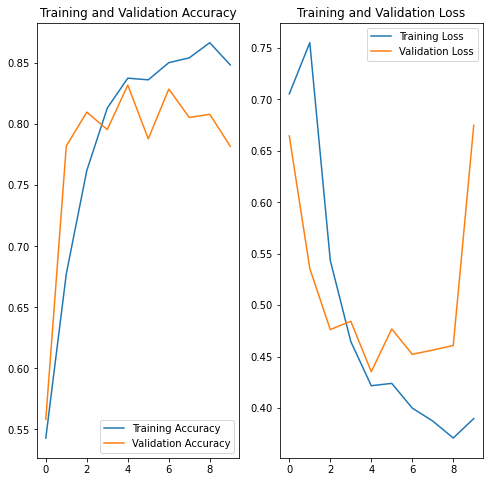

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()